In [402]:
import os
import pandas as pd
import seaborn as sns
import random
from datetime import date
from dateutil.relativedelta import relativedelta
from math import floor

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [20]:
# Based on:
# Lecture notes from Prof. Burc Ulengin
# This blog post: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [21]:
data_folder = '../03.clean-data/'
positive_monthly_return_cutoff = 0.002

## Load Data

In [22]:
hpi = pd.read_csv(os.path.join(data_folder, 'hpi.csv'), parse_dates=['Date']) # Load
hpi.sort_values(['Area', 'Type', 'Date'], inplace=True) # Sort
hpi.reset_index(inplace=True)

## Check for Stationarity

In [23]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
# The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

In [24]:
# Null Hypothesis of Augmented Dickey-Fuller test: series is non-stationary.
# So, if the p value is less than 0.05, we will reject that the series are non-stationary, and conclude that they are stationary.
# If we fail to reject (p > 0.05) then we fail to reject that the series is non-stationary.
# So we think that the the series is non-stationary if p > 0.05
def is_stationary(x, p=0.05, **kwargs):
    return (adfuller(x, **kwargs)[1] < p)
is_panel_stationary = hpi[hpi['HPI'].notnull()].groupby(['Area', 'Type'])['HPI'].apply(is_stationary)
is_panel_stationary

Area                    Type                  
Adjala-Tosorontio       Composite                 False
                        Single-Family Detached    False
Ajax                    Apartment                 False
                        Composite                 False
                        Single-Family Attached    False
                                                  ...  
Whitchurch-Stouffville  Apartment                  True
                        Composite                 False
                        Single-Family Attached    False
                        Single-Family Detached    False
                        Townhouse                 False
Name: HPI, Length: 286, dtype: bool

In [25]:
is_panel_stationary.sum() / len(is_panel_stationary)

0.006993006993006993

In [26]:
# We have evidence that over 99% of the series are non-stationary.
# This is the statistical reason for the need use either returns or differences.

## Get Returns

In [27]:
hpi_returns = hpi.copy()

In [28]:
hpi_returns['HPI.L1'] = hpi_returns.groupby(['Area', 'Type'])['HPI'].shift(1)
hpi_returns['MonthlyChangeInHPI'] = (hpi_returns['HPI'] - hpi_returns['HPI.L1']) / hpi_returns['HPI.L1']

## Check for Stationarity in Returns

In [30]:
is_panel_stationary = hpi_returns[hpi_returns['MonthlyChangeInHPI'].notnull()].groupby(['Area', 'Type'])['MonthlyChangeInHPI'].apply(is_stationary)
is_panel_stationary

Area                    Type                  
Adjala-Tosorontio       Composite                 True
                        Single-Family Detached    True
Ajax                    Apartment                 True
                        Composite                 True
                        Single-Family Attached    True
                                                  ... 
Whitchurch-Stouffville  Apartment                 True
                        Composite                 True
                        Single-Family Attached    True
                        Single-Family Detached    True
                        Townhouse                 True
Name: MonthlyChangeInHPI, Length: 286, dtype: bool

In [31]:
is_panel_stationary.sum() / len(is_panel_stationary)

0.951048951048951

## Train VAR Model for One Window

In [498]:
window_length = 36  # months before the date we run the forecast on.|

In [517]:
# Get a smaller set of panels to avoid non-definite matrices.

city_of_toronto_areas = hpi_returns[hpi_returns['Area'].str.startswith('Toronto')].copy()
no_townhouses = city_of_toronto_areas['Type'] != 'Townhouse'  # Townhouse indices have some data missingness & seem to be prone to noise.
k = 10  # Has to be less than half of the window_length
panels = city_of_toronto_areas[no_townhouses].drop_duplicates(['Area', 'Type'])[['Area', 'Type']].sample(n=k)
panels



,Area,Type
23233,Toronto W06,Composite
14993,Toronto E01,Composite
8916,Toronto C03,Single-Family Attached
15920,Toronto E03,Apartment
21276,Toronto W02,Single-Family Attached
17671,Toronto E06,Single-Family Attached
21070,Toronto W02,Apartment
12830,Toronto C12,Apartment
21585,Toronto W03,Apartment
21791,Toronto W03,Single-Family Attached


In [518]:
start_date = pd.to_datetime(date(2012, 1, 1))
end_date = start_date + relativedelta(months=window_length)
train = (
    hpi_returns
        [hpi_returns['Date'].between(start_date, end_date)]
        .merge(panels, on=['Area', 'Type'], how='inner')
        .pivot_table(values=['MonthlyChangeInHPI'], index=['Date'], columns=['Area', 'Type'])
)
train.index = pd.DatetimeIndex(train.index).to_period('M')
date_of_forecast_being_made = train.index.max()
date_of_forecasted_value = end_date + relativedelta(months=1)
start_date, end_date, date_of_forecast_being_made, date_of_forecasted_value


(Timestamp('2012-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Period('2015-01', 'M'),
 Timestamp('2015-02-01 00:00:00'))

In [519]:
model = VAR(train)
criterion = {}
models = {}

for lag_order in range(1, window_length):
    try:
        fitted = model.fit(lag_order)
        models[lag_order] = fitted
        criterion[lag_order] = fitted.aic
    except:
        pass
selected_lag_order = list(dict(sorted(criterion.items(), key=lambda x:x[1])).keys())[0]
fitted = models[selected_lag_order]

<AxesSubplot:>

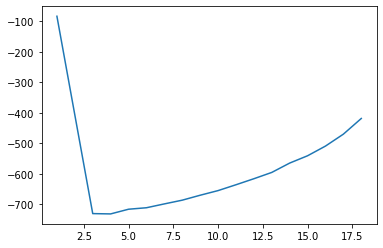

In [520]:
sns.lineplot(x=list(criterion.keys()), y=list(criterion.values()))

In [521]:
lag_order = fitted.k_ar
lag_order

4

In [525]:
fitted.forecast(y=train.values[-lag_order:], steps=1)

array([[ 0.02129135,  0.04531384,  0.01818572, -0.00039472,  0.01353676,
         0.01628476,  0.01732345, -0.01588253,  0.0135679 ,  0.03164722]])

In [527]:
forecast = pd.DataFrame(columns=train.columns, index=pd.DatetimeIndex([date_of_forecasted_value]), data=fitted.forecast(y=train.values[-lag_order:], steps=1))
forecast



MonthlyChangeInHPI                                      \
Area                  Toronto C03 Toronto C12 Toronto E01 Toronto E03   
Type       Single-Family Attached   Apartment   Composite   Apartment   
2015-02-01               0.021291    0.045314    0.018186   -0.000395   

                                                                      \
Area                  Toronto E06 Toronto W02                          
Type       Single-Family Attached   Apartment Single-Family Attached   
2015-02-01               0.013537    0.016285               0.017323   

                                                           
Area       Toronto W03                        Toronto W06  
Type         Apartment Single-Family Attached   Composite  
2015-02-01   -0.015883               0.013568    0.031647

## VAR model for all Toronto Meighbourhoods & for all dates.

In [ ]:
# Loop through all dates, just like in 05.A.
# Inside the loop, loop again through all sets of 10 neighbourhoods.
# Or just do the "Composite" for 12 or so neighbourhoods.